In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Set file directory**

In [ ]:
path = "/content/drive/My Drive/Covid-YT/"

In [ ]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir ./

Writing setup.sh


In [ ]:
!sh setup.sh

Cloning into 'apex'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 7274 (delta 9), reused 6 (delta 0), pack-reused 7255
Receiving objects: 100% (7274/7274), 13.86 MiB | 21.09 MiB/s, done.
Resolving deltas: 100% (4910/4910), done.
Created temporary directory: /tmp/pip-ephem-wheel-cache-c2zmp584
Created temporary directory: /tmp/pip-req-tracker-a_0x3_z2
Created requirements tracker '/tmp/pip-req-tracker-a_0x3_z2'
Created temporary directory: /tmp/pip-install-ve3dbl3y
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-9l0y5dp1
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-a_0x3_z2'
    Running setup.py (path:/tmp/pip-req-build-9l0y5dp1/setup.py) egg_info for package from file:///content/apex
    Running command python setup.py egg_info


    torch.__version__  = 1.5.0+cu101


    running egg_info
    creating /tmp/pip-req-build-9l0y5dp1/pip-

In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 194kB 3.5MB/s 
     |████████████████████████████████| 204kB 10.4MB/s 
     |████████████████████████████████| 675kB 11.2MB/s 
     |████████████████████████████████| 3.8MB 17.2MB/s 
     |████████████████████████████████| 890kB 38.1MB/s 
     |████████████████████████████████| 1.1MB 25.4MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=55cc30851f558d1111aca2dc2385715a6627d43ade36d5981cdb5f4097e7eeed
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=1728e0000a6e7a110c5e7ca96a238ec1352346a96cfc1eb2da9b32fca1b36d0f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built seqeval sacremoses


In [ ]:
!pip install arviz==0.7.0
!pip install pymc3==3.8

     |████████████████████████████████| 1.5MB 3.4MB/s 
     |████████████████████████████████| 4.1MB 18.7MB/s 
     |████████████████████████████████| 327kB 36.9MB/s 
     |████████████████████████████████| 911kB 3.5MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [ ]:
from simpletransformers.classification import ClassificationModel
from simpletransformers.classification import MultiLabelClassificationModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, cross_val_predict
from statistics import mean, stdev
from scipy.stats import ttest_ind

import spacy
from scipy.sparse import hstack
from spacy.lang.en.stop_words import STOP_WORDS
import string

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import pymc3 as pm
import arviz as az
import seaborn as sns
az.style.use('arviz-darkgrid')


# Preprocessing

In [ ]:
comments_df = pd.read_csv(path + "labeled_comments.csv")
comments_df.head()

,agree,conspiracy,video_id,comment,comment_id
0,NaN,NaN,-1qaKpAQDW0,"Hmm, I heard patient 0 is in the state of Wash...",UgxiknpaaVmLj4lPgIB4AaABAg
1,1.0,NaN,-1qaKpAQDW0,True what he is saying..PEOPLE at airports are...,Ugx1rK3UAqMWqTAqPSx4AaABAg
2,NaN,1.0,-1qaKpAQDW0,This has been part of the Agenda for many year...,Ugy0jbRgYJU26BOz9JV4AaABAg
3,NaN,1.0,-1qaKpAQDW0,They thought that they would be able to destab...,UgxZCWJJTNKc8Ef-y3p4AaABAg
4,NaN,NaN,-1qaKpAQDW0,Tea tree oil has kept me from suffering from c...,Ugw4mMdhaZxTvUKYWp94AaABAg


In [ ]:
def remove_urls(x):
  return re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', " ", str(x))

comments_df = comments_df.fillna(0)
comments_df["text"] = comments_df.comment.apply(remove_urls)
comments_df = comments_df[comments_df.text != " "].copy()

In [ ]:
print("Agreement")
print(comments_df.agree.value_counts() / comments_df.shape[0] * 100)
print("Conspiracy")
print(comments_df.conspiracy.value_counts() / comments_df.shape[0] * 100)
print("Strong Belief: ", comments_df[(comments_df.agree == 1.0) | (comments_df.conspiracy == 1.0)].shape[0] / 
                comments_df.shape[0] * 100)
print("Disbelief: ", comments_df[(comments_df.agree == -1.0) | (comments_df.conspiracy == -1.0)].shape[0] / 
                comments_df.shape[0] * 100)


Agreement
 0.0    83.437892
 1.0    12.515684
-1.0     4.046424
Name: agree, dtype: float64
Conspiracy
 0.0    78.920954
 1.0    19.730238
-1.0     1.348808
Name: conspiracy, dtype: float64
Strong Belief:  32.151819322459225
Disbelief:  5.144291091593475


In [ ]:
def get_labels(x):
  agree = int(x[0])
  conspiracy = int(x[1])
  if agree == -1:
    agree = 0
  if conspiracy == -1:
    conspiracy = 0
  return [agree, conspiracy]

comments_df["label"] = comments_df.apply(get_labels, axis=1)

In [ ]:
def get_belief(x):
  b = 0
  agree = int(x[0])
  conspiracy = int(x[1])
  if agree == 1 or conspiracy == 1:
    b = 1
  return b

comments_df["belief"] = comments_df.apply(get_belief, axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(comments_df["text"], comments_df["label"], test_size=0.2, stratify = comments_df["belief"])
train_df = pd.DataFrame({"text": X_train, "label": y_train})
test_df = pd.DataFrame({"text": X_test, "label": y_test})
train_df.to_csv(path + "train_data.csv", index=False)
test_df.to_csv(path + "test_data.csv", index=False)

# Conspiracy Classification

In [ ]:
train_df = pd.read_csv(path + "train_data.csv")
test_df = pd.read_csv(path + "test_data.csv")
train_df["label"] = train_df.label.apply(lambda x: [int(x[1]), int(x[4])])
test_df["label"] = test_df.label.apply(lambda x: [int(x[1]), int(x[4])])

Train models

In [ ]:
model_names = ["XLNet", "BERT", "RoBERTa"]
pretrain_names = ["xlnet-base-cased", "bert-base-cased", "roberta-base"]

In [ ]:
def run_model(model_name, pretrain_name, train_df, test_df):
  args = {"train_batch_size": 8,
          "eval_batch_size": 8,
          "num_train_epochs": 4,
          "learning_rate": 1e-5,
          "warmup_ratio": 0.1,
          "warmup_steps": 100,
          "reprocess_input_data": True,
          "overwrite_output_dir": True}
  print(model_name)
  model = MultiLabelClassificationModel(model_name.lower(), pretrain_name, num_labels=2, args=args)
  output_directory = path + model_name.lower() + "/"
  model.train_model(train_df, output_dir=output_directory)
  _, train_predictions = model.predict(train_df["text"])
  _, test_predictions = model.predict(test_df["text"])
  train_df[model_name] = [list(p) for p in train_predictions]
  test_df[model_name] = [list(p) for p in test_predictions]

In [ ]:
for model_name, pretrain_name in zip(model_names, pretrain_names):
    run_model(model_name, pretrain_name, train_df, test_df)

XLNet


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:267: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.599109Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 0.680645

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 0.540602

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.780046Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 0.493540Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 0.400341Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.186820


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 0.230674


Running loss: 0.397912


Running loss: 0.035614




BERT



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.575164Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 0.270783


Running loss: 0.292548


Running loss: 0.032880


Running loss: 0.278270Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 0.314255




RoBERTa



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 0.321836Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 0.284430Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 0.250744


Running loss: 0.249618


Running loss: 0.036157


Running loss: 0.042764



In [ ]:
def evaluate_model(model, df):
    agree = {}
    agree_true = [l[0] for l in df["label"].values]
    agree_score = [l[0] for l in df[model].values]
    agree_predict = [1 if l > 0.5 else 0 for l in agree_score]
    agree["precision"], agree["recall"], agree["threshold"] = precision_recall_curve(agree_true, agree_score)
    agree["precision"] = [0] + list(agree["precision"]) + [1]
    agree["recall"] = [1] + list(agree["recall"]) + [0]

    conspiracy = {}
    conspiracy_true = [l[1] for l in df["label"].values]
    conspiracy_score = [l[1] for l in df[model].values]
    conspiracy_predict = [1 if l > 0.5 else 0 for l in conspiracy_score]
    conspiracy["precision"], conspiracy["recall"], conspiracy["threshold"] = precision_recall_curve(conspiracy_true, conspiracy_score)
    conspiracy["precision"] = [0] + list(conspiracy["precision"]) + [1]
    conspiracy["recall"] = [1] + list(conspiracy["recall"]) + [0]
    return agree, conspiracy

In [ ]:
roc_dict ={}
for model in model_names:
  agree, conspiracy = evaluate_model(model, test_df)
  roc_dict[model] = {"agree": agree, "conspiracy": conspiracy}

In [ ]:
# Code to check failed classifications + Confusion matrix

#train_df["conspiracy"] = train_df.label.apply(lambda x: x[1])
#test_df["conspiracy"] = test_df.label.apply(lambda x: x[1])
#train_df["prediction"] = train_df.RoBERTa.apply(lambda x: x[1])
#test_df["prediction"] = test_df.RoBERTa.apply(lambda x: x[1])
#test_df[(test_df.conspiracy==1) & (test_df.prediction<0.5)].sort_values(by="prediction", ascending=True).text.to_list()
#from sklearn.metrics import confusion_matrix
#conspiration_true = [l[1] for l in train_df["label"].values]
#conspiration_score = [l[1] for l in train_df[model].values]
#conspiration_predict = [1 if l > 0.5 else 0 for l in conspiration_score]
#confusion_matrix(conspiration_true, conspiration_predict)

This amazing plot is courtesy of the great Shan Jiang https://github.com/printfoo/misinfo-cscw2018-icwsm2020/blob/master/misinfo-belief-icwsm20/src/eval_experiments.py

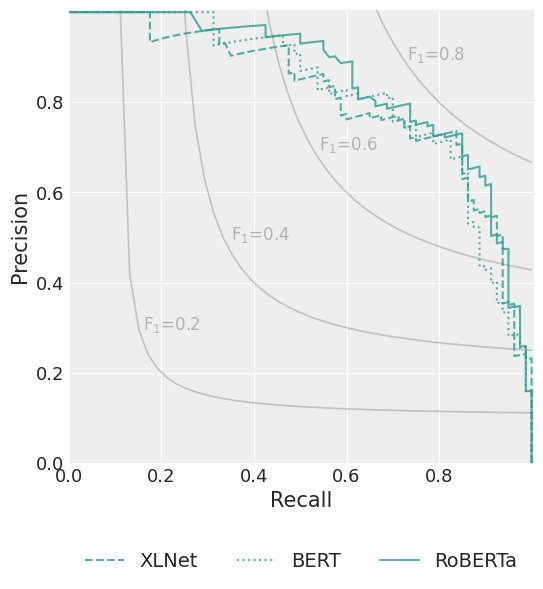

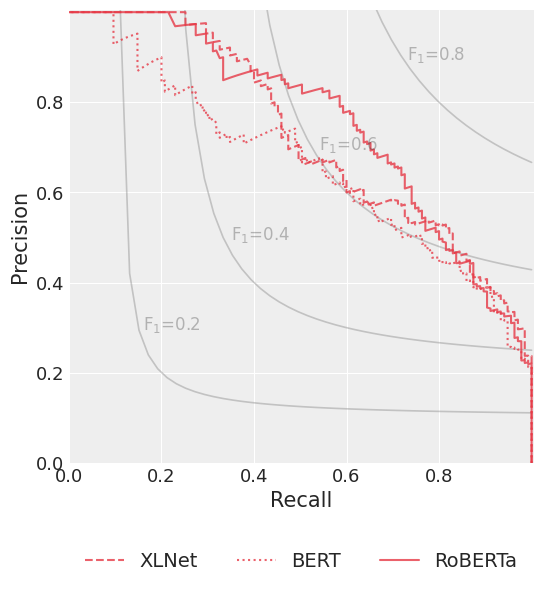

In [ ]:
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["font.size"] = 8
font = FontProperties()
font.set_size(12)
font2 = FontProperties()
font2.set_size(8)
font2.set_weight("bold")
font3 = FontProperties()
font3.set_size(7)

plot_args = {"agree": {
                        "XLNet": {"c": "#2a9d8f", "ls": "--"},
                        "BERT": {"c": "#2a9d8f", "ls": ":"},
                        "RoBERTa": {"c": "#2a9d8f", "ls": "-"}},
              "conspiracy": {"XLNet": {"c": "#e63946", "ls": "--"},
                            "BERT": {"c": "#e63946", "ls": ":"},
                            "RoBERTa": {"c": "#e63946", "ls": "-"}}}

for label in ["agree", "conspiracy"]:
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(6, 6))
    
    # Plots F1 isoheights.
    f_scores = np.linspace(0.2, 0.8, num=4)
    x_locs = [0.16, 0.35, 0.54, 0.73]
    y_locs = [0.295, 0.495, 0.695, 0.895]
    lines = []
    labels = []
    for x_loc, y_loc, f_score in zip(x_locs, y_locs, f_scores):
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = ax.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.4, linewidth=1.2)
        ax.annotate("F$_1$={:0.1f}".format(f_score), xy=(x_loc, y_loc), alpha=0.3, fontproperties=font)

    # Plots model precision recall curves.
    for model in model_names:
      ax.plot(roc_dict[model][label]["recall"], roc_dict[model][label]["precision"], label=model, alpha=0.8, color=plot_args[label][model]["c"],
                        linestyle=plot_args[label][model]["ls"])

    # Other specifications.
    ax.set_xlim([0, 1.005])
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
    ax.set_xlabel("Recall", fontsize = 15)
    ax.set_ylim([0, 1.005])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
    ax.tick_params(labelsize=13)
    ax.set_ylabel("Precision", fontsize = 15)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    leg = ax.legend(bbox_to_anchor=(0.5, -0.18, 0, 0), loc="upper center", ncol=3, borderaxespad=0.)
    #leg.get_frame().set_alpha(0)
    plt.savefig(path + label + ".png")

Run models several times for measurement error

In [ ]:
def run_model_evaluate(model_name, pretrain_name, train_df, test_df, runs):
  train_agree = []
  train_conspiracy = []
  test_agree = []
  test_conspiracy = []
  args = {"train_batch_size": 8,
          "eval_batch_size": 8,
          "num_train_epochs": 4,
          "learning_rate": 1e-5,
          "warmup_ratio": 0.1,
          "warmup_steps": 100,
          "reprocess_input_data": True,
          "overwrite_output_dir": True}
  for i in range(runs):
      model = MultiLabelClassificationModel(model_name.lower(), pretrain_name, num_labels=2, args=args)
      model.train_model(train_df)
      _, train_predictions = model.predict(train_df["text"])
      _, test_predictions = model.predict(test_df["text"])
      train_p = [list(p) for p in train_predictions]
      test_p = [list(p) for p in test_predictions]
      # Agree
      train_true = [l[0] for l in train_df["label"].values]
      train_score = [l[0] for l in train_p]
      train_predict = [1 if l > 0.5 else 0 for l in train_score]
      train_agree.append(f1_score(train_true, train_predict, average="micro"))
      test_true = [l[0] for l in test_df["label"].values]
      test_score = [l[0] for l in test_p]
      test_predict = [1 if l > 0.5 else 0 for l in test_score]
      test_agree.append(f1_score(test_true, test_predict, average="micro"))
      # Conspiracy
      train_true = [l[1] for l in train_df["label"].values]
      train_score = [l[1] for l in train_p]
      train_predict = [1 if l > 0.5 else 0 for l in train_score]
      train_conspiracy.append(f1_score(train_true, train_predict, average="micro"))
      test_true = [l[1] for l in test_df["label"].values]
      test_score = [l[1] for l in test_p]
      test_predict = [1 if l > 0.5 else 0 for l in test_score]
      test_conspiracy.append(f1_score(test_true, test_predict, average="micro"))
  print(model_name)
  print("train_agree", mean(train_agree), stdev(train_agree))
  print("test_agree", mean(test_agree), stdev(test_agree))
  print("train_conspiracy", mean(train_conspiracy), stdev(train_conspiracy))
  print("test_conspiracy", mean(test_conspiracy), stdev(test_conspiracy))

In [ ]:
for model_name, pretrain_name in zip(model_names, pretrain_names):
    run_model_evaluate(model_name, pretrain_name, train_df, test_df, runs=5)

**Results**

XLNet

train_agree 0.9701176470588235 +- 0.0014515102371232755

test_agree 0.9307210031347962 +- 0.0032122102714606787

train_conspiracy 0.9388235294117647 +- 0.005462113049876123

test_conspiracy 0.84858934169279 +- 0.0057161700717274

BERT

train_agree 0.9847843137254901 +-  0.0006443794794178442

test_agree 0.9335423197492163 +- 0.005384189353391131

train_conspiracy 0.9627450980392156 +- 0.0034634356338540317

test_conspiracy 0.8379310344827586 +- 0.00957268431636518

RoBERTa

train_agree 0.9807058823529412 +- 0.0016263875571237425

test_agree 0.9388714733542319 +- 0.004146945628627886

train_conspiracy 0.964078431372549 +- 0.0026248157695186545

test_conspiracy 0.8673981191222571 +- 0.004649654223884418

# Predictions

## Misinformation Videos

In [ ]:
args = {"train_batch_size": 8,
        "eval_batch_size": 8,
        "num_train_epochs": 3,
        "learning_rate": 1e-5,
        "warmup_ratio": 0.1,
        "warmup_steps": 100,
        "reprocess_input_data": True,
        "overwrite_output_dir": True}
rb_model = ClassificationModel('roberta', path + 'roberta/checkpoint-1276-epoch-4/', args=args)

In [ ]:
missing_comments_df = pd.read_csv(path + "non_labeled_comments.csv")
missing_comments_df.shape[0]

29039

In [ ]:
def remove_urls(x):
  return re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', " ", str(x))

missing_comments_df["comment"] = missing_comments_df.comment.apply(remove_urls)

In [ ]:
_, missing_predictions = rb_model.predict(missing_comments_df["comment"])
missing_comments_df["prediction"] = [list(p) for p in missing_predictions]
conspiration_score = [l[1] for l in missing_comments_df["prediction"].values]
conspiration_predict = [1 if l > 0.5 else 0 for l in conspiration_score]
missing_comments_df["conspiracy"] = conspiration_predict
agree_score = [l[0] for l in missing_comments_df["prediction"].values]
agree_predict = [1 if l > 0.5 else 0 for l in agree_score]
missing_comments_df["agree"] = agree_predict

In [ ]:
all_misinfo_df = pd.concat([comments_df[["video_id", "conspiracy", "agree"]], missing_comments_df[["video_id", "conspiracy", "agree"]]])

In [ ]:
counts = all_misinfo_df.groupby("video_id", as_index=False).count()
counts["n_videos"] = counts["conspiracy"]
del counts["conspiracy"]
del counts["agree"]
sumed = all_misinfo_df.groupby("video_id", as_index=False).sum()
sumed["sum_videos"] = sumed["conspiracy"]
sumed["sum_videos_agree"] = sumed["agree"]
del sumed["conspiracy"]
del sumed["agree"]
videos_misinfo = pd.merge(counts[counts.n_videos>20], sumed, on="video_id", how="left")
videos_misinfo["percentage_conspiracy"] = videos_misinfo.sum_videos/ videos_misinfo.n_videos
videos_misinfo["percentage_agree"] = videos_misinfo.sum_videos_agree/ videos_misinfo.n_videos

## Non-misinformation Videos

In [ ]:
factual_comments_df = pd.read_csv(path + "factual_comments.csv", sep=";")
factual_comments_df.shape[0]

119294

In [ ]:
def remove_urls(x):
  return re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', " ", str(x))

factual_comments_df["comment"] = factual_comments_df.comment.apply(remove_urls)

In [ ]:
_, factual_predictions = rb_model.predict(factual_comments_df["comment"])
factual_comments_df["prediction"] = [list(p) for p in factual_predictions]
conspiration_score = [l[1] for l in factual_comments_df["prediction"].values]
conspiration_predict = [1 if l > 0.5 else 0 for l in conspiration_score]
factual_comments_df["conspiracy"] = conspiration_predict
agree_score = [l[0] for l in factual_comments_df["prediction"].values]
agree_predict = [1 if l > 0.5 else 0 for l in agree_score]
factual_comments_df["agree"] = agree_predict

In [ ]:
counts = factual_comments_df.groupby("video_id", as_index=False).count()
counts["n_videos"] = counts["conspiracy"]
del counts["conspiracy"]
del counts["agree"]
sumed = factual_comments_df.groupby("video_id", as_index=False).sum()
sumed["sum_videos"] = sumed["conspiracy"]
sumed["sum_videos_agree"] = sumed["agree"]
del sumed["conspiracy"]
del sumed["agree"]
videos_info = pd.merge(counts[counts.n_videos>20], sumed, on="video_id", how="left")
videos_info["percentage_conspiracy"] = videos_info.sum_videos/ videos_info.n_videos 
videos_info["percentage_agree"] = videos_info.sum_videos_agree/ videos_info.n_videos

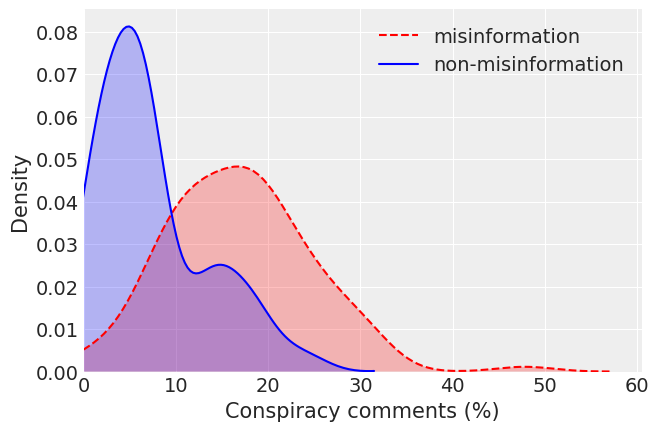

In [ ]:
sns.kdeplot((videos_misinfo["percentage_conspiracy"] * 100).to_list(), label="misinformation", shade=True, color="red", linestyle="--").set(xlim=(0))
sns.kdeplot((videos_info["percentage_conspiracy"] * 100).to_list(), label="non-misinformation", shade=True, color="blue").set(xlim=(0))
plt.xlabel("Conspiracy comments (%)")
plt.ylabel("Density")
plt.savefig(path + "conspiracy_kde.png")
plt.legend();

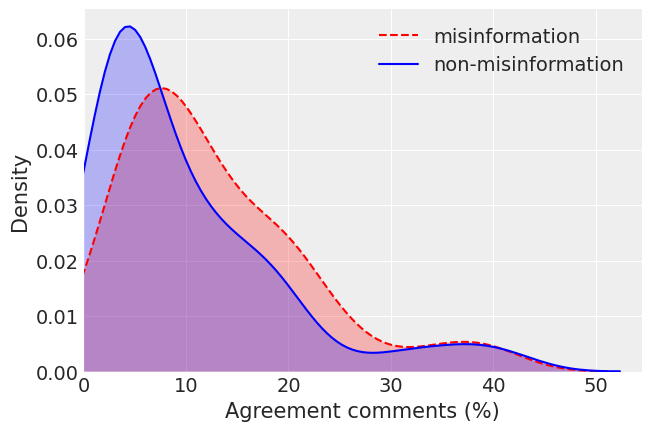

In [ ]:
sns.kdeplot((videos_misinfo["percentage_agree"] * 100).to_list(), label="misinformation", shade=True, color="red", linestyle="--").set(xlim=(0))
sns.kdeplot((videos_info["percentage_agree"] * 100).to_list(), label="non-misinformation", shade=True, color="blue").set(xlim=(0))
plt.xlabel("Agreement comments (%)")
plt.ylabel("Density")
plt.savefig(path + "agree_kde.png")
plt.legend();

In [ ]:
print(videos_misinfo.shape[0])
print(videos_info.shape[0])

113
67


No obvious discriminative feature with agree (as expected)

In [ ]:
videos_info["misinformation"] = 0
videos_misinfo["misinformation"] = 1
yt_videos_df = pd.concat([videos_misinfo[["video_id", "percentage_conspiracy", "misinformation"]], videos_info[["video_id", "percentage_conspiracy", "misinformation"]]])
yt_videos_df.to_csv(path + "yt_ids_conspiracy.csv", index=False)

In [ ]:
misinformation_percentages = yt_videos_df[yt_videos_df.misinformation==1]["percentage_conspiracy"].to_list()
information_percentages = yt_videos_df[yt_videos_df.misinformation==0]["percentage_conspiracy"].to_list()

In [ ]:
ttest_ind(misinformation_percentages, information_percentages, equal_var = False)

Ttest_indResult(statistic=9.20032815448642, pvalue=1.4564006560818858e-16)

# Video Classification

In [ ]:
yt_titles = pd.read_csv(path + "video_titles.csv")
yt_videos_df = pd.read_csv(path + "yt_ids_conspiracy.csv")

In [ ]:
yt_videos_df = pd.merge(yt_videos_df, yt_titles, on="video_id", how="left")

In [ ]:
yt_videos_df.head()

,video_id,percentage_conspiracy,misinformation,title,number_comments
0,-1qaKpAQDW0,0.292683,1,Breaking: Coronavirus Is Bioweapon For Populat...,246
1,-WFa4bHC0Do,0.292763,1,The Depopulation Agenda - Bill Gates Plan to K...,304
2,-_ZpU0kHXLs,0.250000,1,BENJAMIN FULFORD = The Khazarian mob uses viru...,48
3,-hG6DzJ-c-c,0.265973,1,What Happened RIGHT Before The Coronavirus Out...,673
4,0jmhj-vnl5E,0.175439,1,Is Wuhan virus a hit job? A whodunit not to mi...,114


In [ ]:
nlp = spacy.load("en_core_web_sm")
punctuations = string.punctuation

def tokenize_text_data(x):
  comment = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', " ", str(x))
  tokens = nlp(" ".join(comment.split())) # remove double spaces
  filtered_words = []
  for token in tokens:
    if token.is_stop==False and token.text not in punctuations:
      filtered_words.append(token.text.lower())
  return filtered_words

In [ ]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_text_data)
train_feature_set = tfidf_vectorizer.fit_transform(yt_videos_df["title"].values)

**Only text features**

In [ ]:
lr_classifier = LogisticRegression()

In [ ]:
cross_val_score(lr_classifier, train_feature_set, yt_videos_df["misinformation"], scoring="accuracy", cv=10).mean()

0.6277777777777777

In [ ]:
svm_clf = SVC(random_state=42)
param_grid = [{"kernel": ["linear"], "C": [1, 100, 1000, 5000]},
              {"kernel": ["rbf", "sigmoid"],  "gamma":["auto", "scale"], "C": [1, 100, 1000, 5000]}]
grid_search = GridSearchCV(svm_clf, param_grid, cv=10, scoring="accuracy")
grid_search.fit(train_feature_set, yt_videos_df["misinformation"])
print(grid_search.best_params_)
print(grid_search.best_score_)
svm_model = grid_search.best_estimator_

{'C': 1, 'kernel': 'linear'}
0.6555555555555556


In [ ]:
forest_classifier = RandomForestClassifier(random_state=42)
param_grid = [{"n_estimators": [500, 1000], "max_depth": [50, 100, 500, None]},
              {"bootstrap": [False],  "n_estimators": [500, 1000], "max_depth": [50, 100, 500, None]}]
grid_search = GridSearchCV(forest_classifier, param_grid, cv=10, scoring="accuracy")
grid_search.fit(train_feature_set, yt_videos_df["misinformation"])
print(grid_search.best_params_)
print(grid_search.best_score_)
forest_model = grid_search.best_estimator_

{'max_depth': 50, 'n_estimators': 500}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
grid_search.best_score_

0.6444444444444446

In [ ]:
importances = forest_model.feature_importances_
indices = np.argsort(importances)[::-1]
features_dict_inverted = tfidf_vectorizer.vocabulary_
features_dict = {}
for k, v in features_dict_inverted.items():
  features_dict[v] = k
features_dict[len(tfidf_vectorizer.vocabulary_)] = "Conspiracy Feature"
for f in range(20):
    print(f + 1, features_dict[indices[f]], importances[indices[f]])

1 coronavirus 0.04742581281514215
2 covid-19 0.03501068054355626
3 bioweapon 0.01711022637575753
4 china 0.014453158612592195
5 crisis 0.012364870119456554
6 cases 0.011092273499092208
7 conspiracy 0.01104988834189076
8 update 0.010978491433001347
9 man 0.010914022680536472
10 new 0.010422475392457676
11 outbreak 0.010261310120484932
12 france 0.009481068749064283
13 bbc 0.007953707759617365
14 iran 0.007679532995900965
15 epidemic 0.007591258335873856
16 case 0.006800593611418744
17 says 0.0066657263589701
18 19 0.006527314594562009
19 intelligence 0.006449081602609368
20 symptoms 0.006195205897149328


**Only conspiracy feature**

In [ ]:
conspiracy_feature = np.array(yt_videos_df["percentage_conspiracy"].to_list()).reshape(-1, 1)

In [ ]:
cross_val_score(lr_classifier, conspiracy_feature, yt_videos_df["misinformation"], scoring="accuracy", cv=10).mean()

0.6277777777777777

In [ ]:
svm_clf = SVC(random_state=42)
param_grid = [{"kernel": ["linear"], "C": [1, 100, 1000, 5000]},
              {"kernel": ["rbf", "sigmoid"],  "gamma":["auto", "scale"], "C": [1, 100, 1000, 5000]}]
grid_search = GridSearchCV(svm_clf, param_grid, cv=10, scoring="accuracy")
grid_search.fit(conspiracy_feature, yt_videos_df["misinformation"])
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.8111111111111111


In [ ]:
cross_val_score(forest_classifier, conspiracy_feature, yt_videos_df["misinformation"], scoring="accuracy", cv=10).mean()

0.7222222222222223

In [ ]:
# Using the whole data (overfitting)
model = forest_classifier.fit(conspiracy_feature, yt_videos_df["misinformation"])
predictions = model.predict(conspiracy_feature)
accuracy_score(predictions, yt_videos_df["misinformation"])

0.9777777777777777

**Conspiracy + Text**

In [ ]:
train_feature_set_extended = hstack((train_feature_set,np.array(yt_videos_df.percentage_conspiracy.to_list())[:,None]))

In [ ]:
cross_val_score(lr_classifier, train_feature_set_extended, yt_videos_df["misinformation"], scoring="accuracy", cv=10).mean()

0.6444444444444445

In [ ]:
svm_clf = SVC(random_state=42)
param_grid = [{"kernel": ["linear"], "C": [1, 100, 1000, 5000]},
              {"kernel": ["rbf", "sigmoid"],  "gamma":["auto", "scale"], "C": [1, 100, 1000, 5000]}]
grid_search = GridSearchCV(svm_clf, param_grid, cv=10, scoring="accuracy")
grid_search.fit(train_feature_set_extended, yt_videos_df["misinformation"])
print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.7777777777777778


In [ ]:
forest_classifier = RandomForestClassifier(random_state=42)
param_grid = [{"n_estimators": [500, 1000], "max_depth": [50, 100, 500, None]},
              {"bootstrap": [False],  "n_estimators": [500, 1000], "max_depth": [50, 100, 500, None]}]
grid_search = GridSearchCV(forest_classifier, param_grid, cv=10, scoring="accuracy")
grid_search.fit(train_feature_set_extended, yt_videos_df["misinformation"])
print(grid_search.best_params_)
print(grid_search.best_score_)
forest_model_all = grid_search.best_estimator_

{'max_depth': 50, 'n_estimators': 500}
0.8222222222222222


Are videos with few comments hard to predict?

In [ ]:
y_train = yt_videos_df["misinformation"]
y_predicted = cross_val_predict(forest_model_all, train_feature_set_extended, y_train, cv=10)
wrong_forest = [i for i in range(len(y_train)) if y_train[i] != y_predicted[i]]
right_forest = [i for i in range(len(y_train)) if y_train[i] == y_predicted[i]]

In [ ]:
comments_list  = yt_videos_df["number_comments"].to_list()
wrong_comment_numbers = [comments_list[x] for x in wrong_forest]
right_comment_numbers = [comments_list[x] for x in right_forest]

In [ ]:
wrong_comment_numbers_small = []
right_comment_numbers_small = []
for l in wrong_comment_numbers:
  if l <= 100:
    wrong_comment_numbers_small.append(l)
right_comment_numbers_small = []
for l in right_comment_numbers:
  if l <= 100:
    right_comment_numbers_small.append(l)

In [ ]:
len(right_comment_numbers) / (len(wrong_comment_numbers) + len(right_comment_numbers))

0.8222222222222222

In [ ]:
len(right_comment_numbers_small) / (len(wrong_comment_numbers_small) + len(right_comment_numbers_small))

0.8524590163934426

Top 10 features

In [ ]:
# Using the whole data (overfitting)
forest_model = forest_classifier.fit(train_feature_set, yt_videos_df["misinformation"])
predictions = model.predict(train_feature_set)
accuracy_score(predictions, yt_videos_df["misinformation"])

1.0

In [ ]:
importances = forest_model_all.feature_importances_
indices = np.argsort(importances)[::-1]
features_dict_inverted = tfidf_vectorizer.vocabulary_
features_dict = {}
for k, v in features_dict_inverted.items():
  features_dict[v] = k
features_dict[len(tfidf_vectorizer.vocabulary_)] = "conspiracy_percentage"
for f in range(20):
    print(f + 1, features_dict[indices[f]], importances[indices[f]])

1 conspiracy_percentage 0.19258314470661145
2 coronavirus 0.029541125917806207
3 covid-19 0.02809296705248499
4 china 0.014199363011009205
5 man 0.012425538777212447
6 bioweapon 0.012419424482469486
7 conspiracy 0.01101305927426168
8 new 0.010339660239772768
9 update 0.00873326076181883
10 cases 0.008306459562825922
11 outbreak 0.007242885460645844
12 france 0.006667654632528438
13 dr 0.006482449635215223
14 intelligence 0.006417257503924745
15 epidemic 0.00530860177617705
16 wuhan 0.005276904311219113
17 special 0.005262978638710732
18 iran 0.005221096184620924
19 case 0.0052071115925802465
20 virus 0.005203799469873284


In [ ]:
features = list(indices[: 11])
X_features = train_feature_set_extended.A[:, features]

In [ ]:
features_df = pd.DataFrame(X_features)
features_df.columns = [features_dict[x] for x in list(indices[: 11])]

In [ ]:
features_df.head()

,conspiracy_percentage,coronavirus,covid-19,china,man,bioweapon,conspiracy,new,update,cases,outbreak
0,0.292683,0.165277,0.0,0.0,0.0,0.362926,0.0,0.0,0.0,0.0,0.000000
1,0.292763,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.250000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.265973,0.123178,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.305255
4,0.175439,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


# Bayesian Modeling

Amazing correlation plot, courtesy of PyMC3's documentation

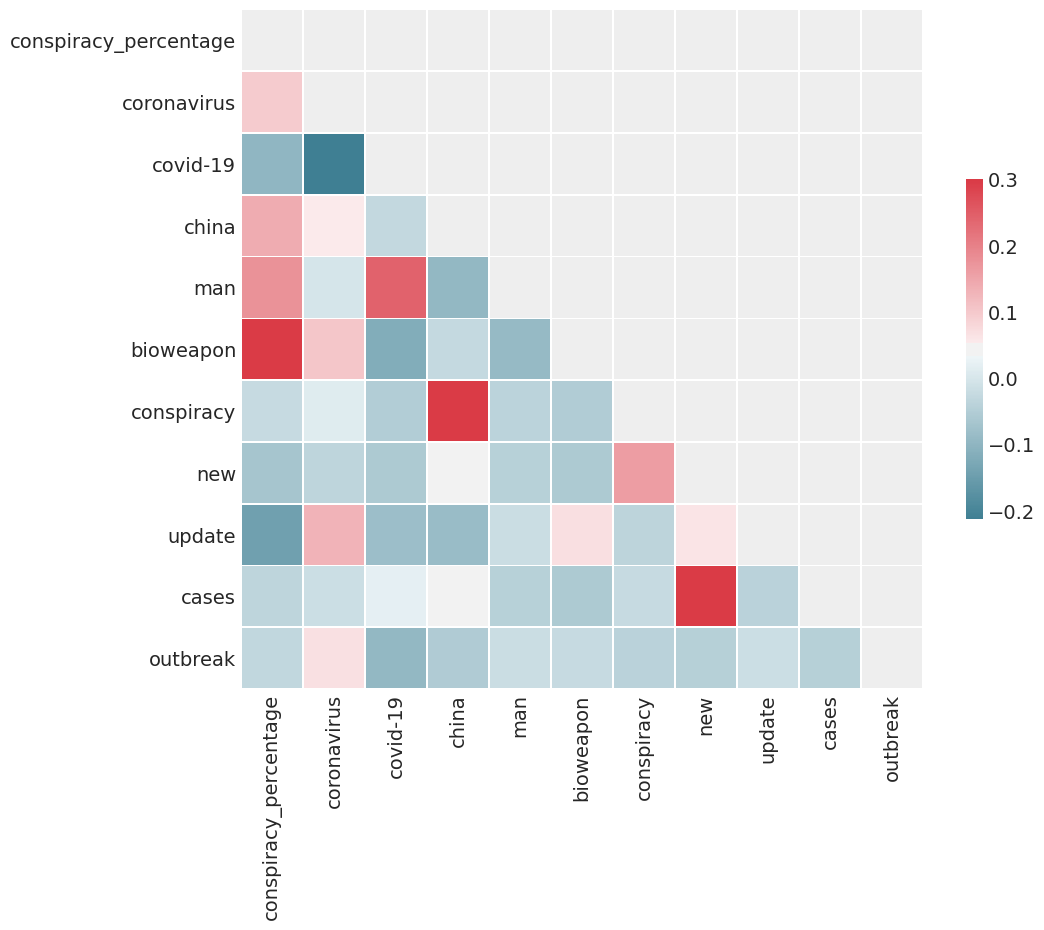

In [ ]:
corr = features_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

In [ ]:
data = features_df
data["covid19"] = data["covid-19"]
del data["covid-19"]
data["misinformation"] = yt_videos_df["misinformation"]
data.to_csv(path + "bayes_data.csv", index=False)

In [ ]:
data = pd.read_csv(path + "bayes_data.csv")
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('misinformation ~ conspiracy_percentage +	coronavirus +	covid19 + china	+ man +	bioweapon +	conspiracy + new + update +	cases +	outbreak',
                            data,
                            family=pm.glm.families.Binomial())
    trace = pm.sample(2000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [outbreak, cases, update, new, conspiracy, bioweapon, man, china, covid19, coronavirus, conspiracy_percentage, Intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:10<00:00, 290.72it/s]


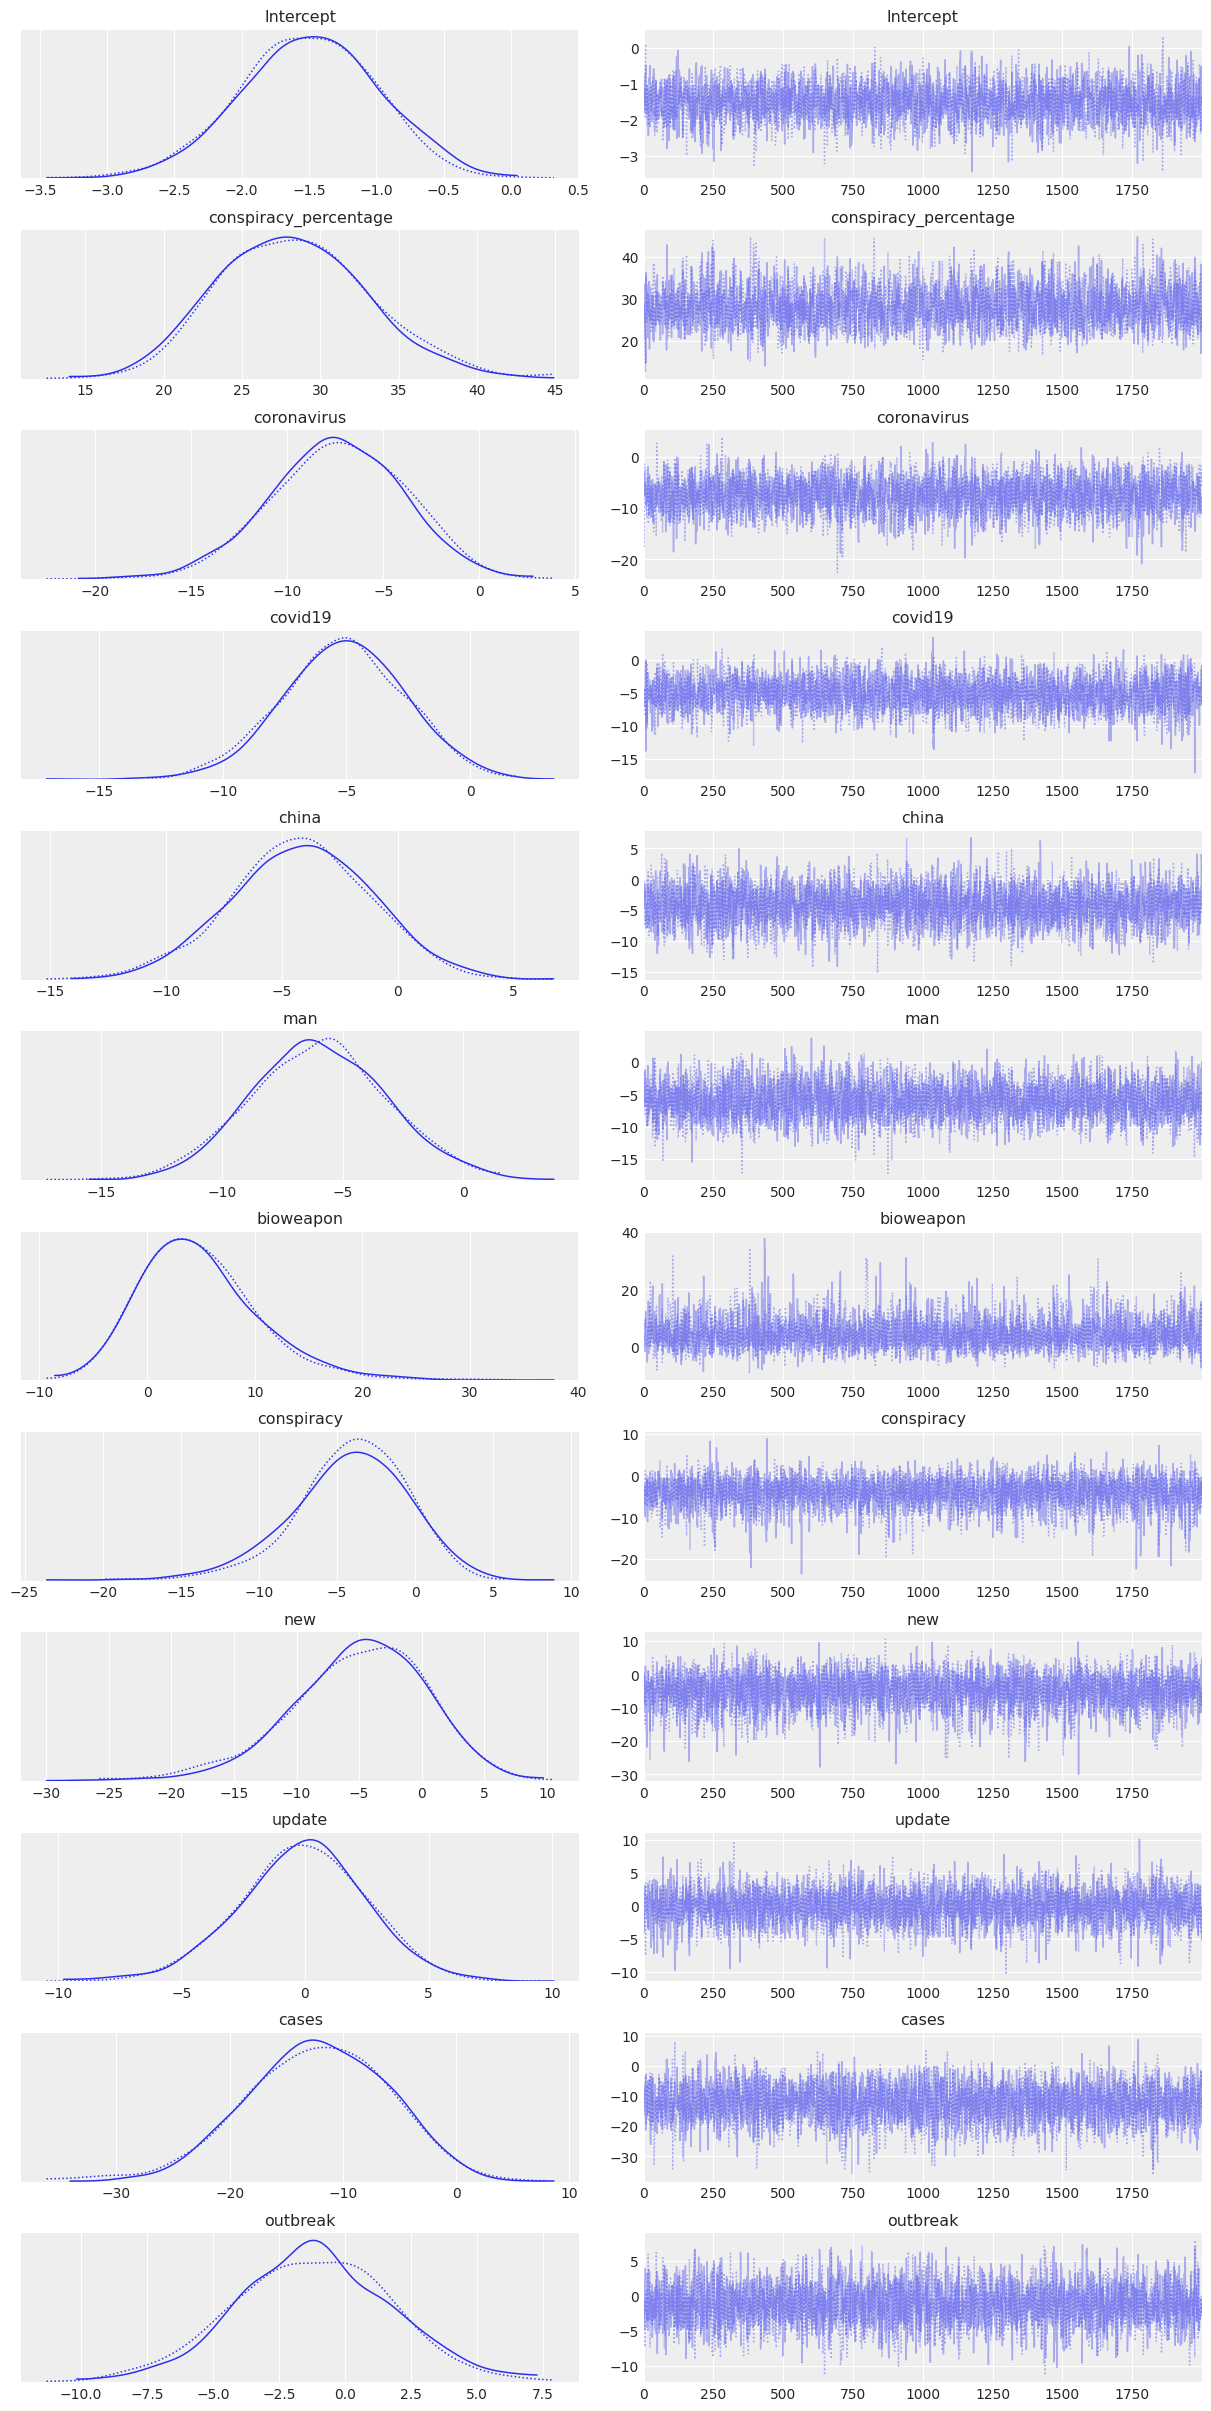

In [ ]:
pm.traceplot(trace);

In [ ]:
pm.summary(trace, credible_interval=0.98)

,mean,sd,hpd_1%,hpd_99%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.510,0.509,-2.754,-0.410,0.010,0.007,2572.0,2552.0,2577.0,2726.0,1.0
conspiracy_percentage,28.247,4.763,18.193,39.944,0.097,0.069,2430.0,2395.0,2454.0,2798.0,1.0
coronavirus,-7.455,3.427,-15.568,0.007,0.062,0.046,3057.0,2738.0,3094.0,2854.0,1.0
covid19,-5.168,2.449,-11.080,0.102,0.043,0.032,3297.0,2897.0,3316.0,2654.0,1.0
china,-4.217,3.015,-11.229,2.627,0.047,0.038,4063.0,3216.0,4086.0,2352.0,1.0
man,-6.036,2.794,-12.248,0.516,0.047,0.035,3541.0,3279.0,3542.0,3062.0,1.0
bioweapon,4.814,5.541,-6.401,19.317,0.108,0.100,2624.0,1542.0,3635.0,1938.0,1.0
conspiracy,-4.237,3.730,-13.960,3.719,0.069,0.059,2963.0,2006.0,3340.0,2227.0,1.0
new,-5.134,5.396,-18.928,6.386,0.091,0.083,3529.0,2130.0,3874.0,2473.0,1.0
update,-0.151,2.549,-6.569,5.687,0.039,0.041,4312.0,1955.0,4345.0,2889.0,1.0


In [ ]:
with pm.Model() as logistic_model_simple:
    pm.glm.GLM.from_formula('misinformation ~ conspiracy_percentage',
                            data,
                            family=pm.glm.families.Binomial())
    trace_simple = pm.sample(3000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [conspiracy_percentage, Intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:04<00:00, 705.03it/s]
The number of effective samples is smaller than 25% for some parameters.


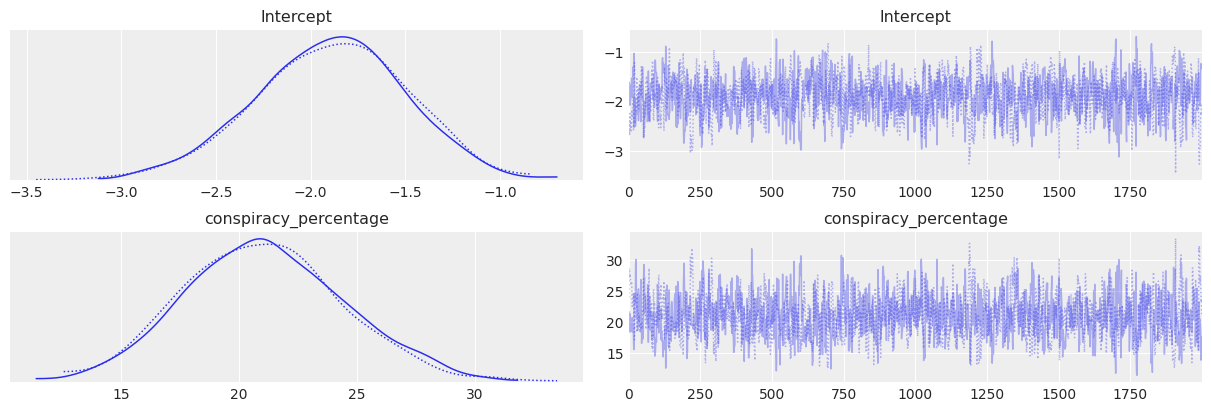

In [ ]:
pm.traceplot(trace_simple);

In [ ]:
pm.summary(trace_simple, credible_interval=0.98)

,mean,sd,hpd_1%,hpd_99%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.901,0.396,-2.859,-1.039,0.013,0.009,918.0,913.0,918.0,1041.0,1.0
conspiracy_percentage,21.026,3.369,13.309,28.613,0.110,0.078,944.0,937.0,947.0,1147.0,1.0


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


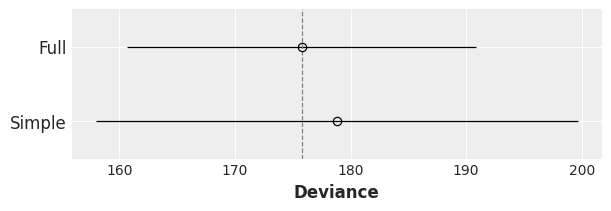

In [ ]:
dfwaic = az.compare({logistic_model_simple: trace_simple, logistic_model: trace}, ic='WAIC', scale='deviance')
dfwaic.index = ["Full", "Simple"]
az.plot_compare(dfwaic, insample_dev=False, plot_ic_diff=False);
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.xlabel("Deviance", fontsize=12, weight='bold')
plt.savefig(path + "models_waic.png")

**Interpretation**

The empty circle represents the values of WAIC and the black error bars associated with them are the values of the standard deviation of WAIC.

The value of the lowest WAIC is also indicated with a vertical dashed grey line to ease comparison with other WAIC values.

For all models except the top-ranked one we also get a triangle indicating the value of the difference of WAIC between that model and the top model and a grey errobar indicating the standard error of the differences between the top-ranked WAIC and WAIC for each model.